In [1]:
import torch
import numpy as np
import pandas as pd
import peakutils
import abel
import os
from torch.nn import functional as F
from matplotlib import pyplot as plt
from scipy.stats import entropy
from ruamel.yaml import YAML

from dii.models.base import valid_models
from dii.visualization.visualize import radial_profile
from dii.pipeline.datautils import get_benchmark_imageset

plt.style.use("publication")

/home/kelvin/anaconda3/envs/ion-image/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory /home/kelvin/Dropbox (MIT)/Projects/deep-ion-image/notebooks/reports exists and is not empty.
  warnings.warn(*args, **kwargs)


In [2]:
def get_profile_peaks(x: np.ndarray, y: np.ndarray, thres=0.05):
    idx = peakutils.indexes(y, thres=thres)
    centers = peakutils.interpolate(x, y, ind=idx)
    return idx, centers

# Model testing report

This notebook is generated using `papermill`.

## Parameter definitions

In [3]:
# Parameter cell; do not edit!
model_kwargs = {
    "in_channels": 1,
    "out_channels": 1,
    "latent_dim": 64,
    "activation": "silu"
}
image_index = 50
models_path = "../../models/"
benchmark_path = "../../data/processed"
n_images = 128
model_name = "baseline"
probabilistic = False
img_center = (64, 64)
output_root = "outputs/"

In [4]:
# Parameters
model_kwargs = {
    "in_channels": 1,
    "out_channels": 1,
    "latent_dim": 64,
    "activation": "silu",
    "pixel_hidden": 64,
    "pixel_layers": 5,
}
probabilistic = True
model_name = "pixelvae"


In [5]:
# output path is where model specific results go
# agg path is a YAML with the combined statistics for summarizing across models
output_path = f"{output_root}{model_name}/"
agg_path = f"{output_root}combined_statistics.yml"

In [6]:
try:
    os.mkdir(output_path)
except:
    pass

## Model determination and loading

In [7]:
# figure out what model we are using with the mapping
model = valid_models.get(model_name, None)

if not model:
    raise KeyError(f"{model_name} is not a valid model in the `dii` codebase! Try again!")

In [8]:
model_obj = model(**model_kwargs)
model_obj.load_state_dict(torch.load(f"{models_path}{model_name}.pt"))

# make sure we have the correct behavior for everything
model_obj.eval();

## Data set loading

In [9]:
input_images, target_images = get_benchmark_imageset(benchmark_path, n_images)

## Model predictions

In [10]:
with torch.no_grad():
    recon = model_obj(input_images)

### Calculating the mean reconstruction error

In [11]:
recon_error = F.binary_cross_entropy(recon, target_images).item()

In [12]:
print(f"Mean reconstruction error: {recon_error:.2f}")

Mean reconstruction error: 0.14


### Finding the best and worst images

In [13]:
# this calculates the pixelwise loss
errors = F.binary_cross_entropy(recon, target_images, reduction="none")

In [14]:
# calculate the highest errors to identify which images are worse
img_errors = errors.mean((1, 2, 3))
worst_idx = torch.argsort(img_errors)[-5:]
best_idx = torch.argsort(img_errors)[:5]

worst_error = img_errors.max().item()
best_error = img_errors.min().item()

### Visualizing the worst images

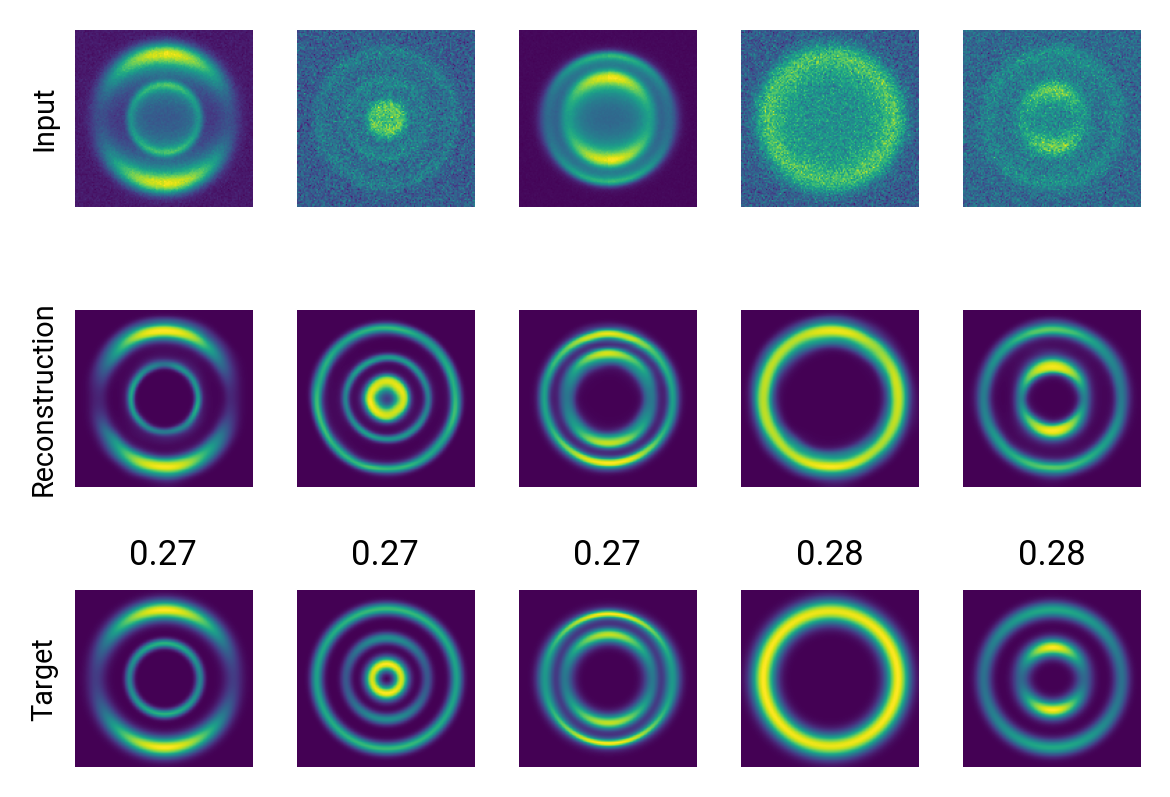

In [15]:
fig, axarray = plt.subplots(3, 5, figsize=(4, 3), sharex=True, sharey=True)

for row, (target, title) in enumerate(zip([input_images, recon, target_images], ["Input", "Reconstruction", "Target"])):
    images = target[worst_idx]
    for col, image in enumerate(images):
        # get rid of the channel dimension
        axarray[row, col].imshow(image.squeeze())
        axarray[row, col].set(xticks=[], yticks=[])
        for _, spine in axarray[row, col].spines.items():
            spine.set_visible(False)
    axarray[row, 0].set_ylabel(title, rotation=90.)
for col, value in enumerate(img_errors[worst_idx]):
    axarray[-1, col].set(title=f"{value:.2f}")
fig.tight_layout()
fig.savefig(f"{output_path}{model_name}_worstimgs.png", dpi=600)

### Visualizing the best images

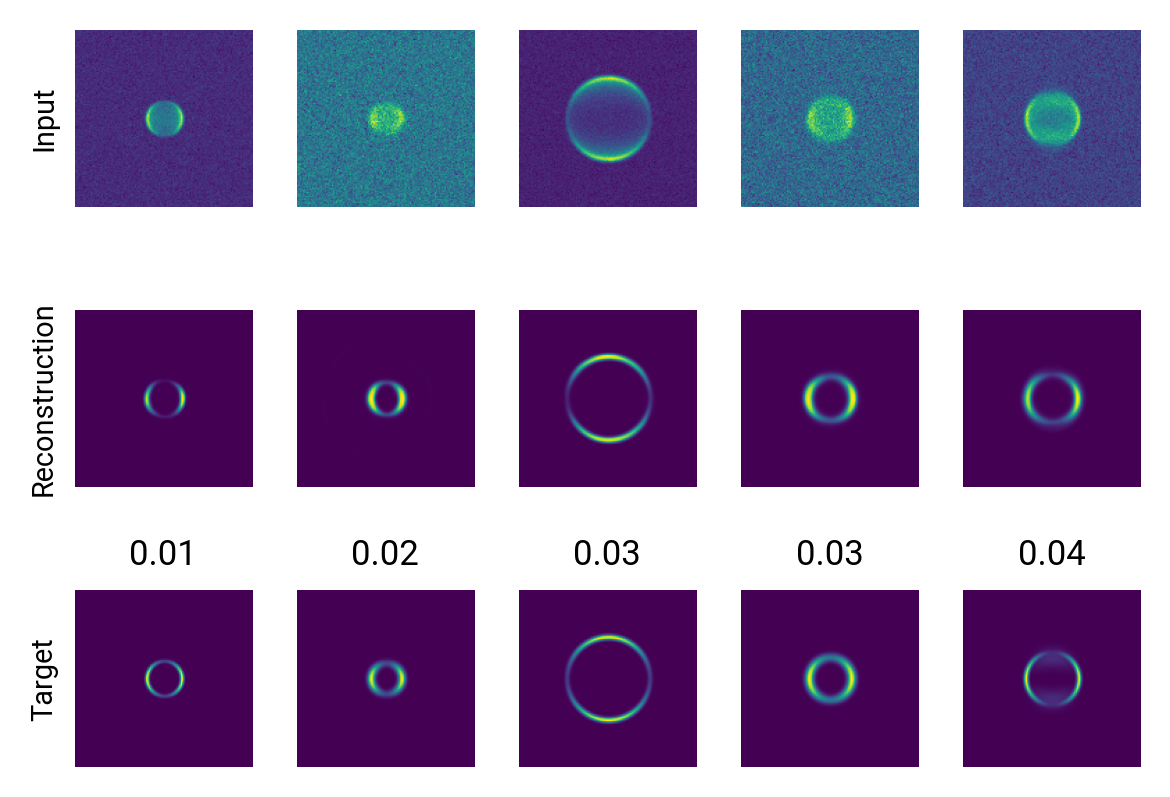

In [16]:
fig, axarray = plt.subplots(3, 5, figsize=(4, 3), sharex=True, sharey=True)

for row, (target, title) in enumerate(zip([input_images, recon, target_images], ["Input", "Reconstruction", "Target"])):
    images = target[best_idx]
    for col, image in enumerate(images):
        # get rid of the channel dimension
        axarray[row, col].imshow(image.squeeze())
        axarray[row, col].set(xticks=[], yticks=[])
        for _, spine in axarray[row, col].spines.items():
            spine.set_visible(False)
    axarray[row, 0].set_ylabel(title, rotation=90.)
for col, value in enumerate(img_errors[best_idx]):
    axarray[-1, col].set(title=f"{value:.2f}")
fig.tight_layout()
fig.savefig(f"{output_path}{model_name}_bestimgs.png", dpi=600)

## Common ground: compare one image across models

### Show what the reconstruction looks like

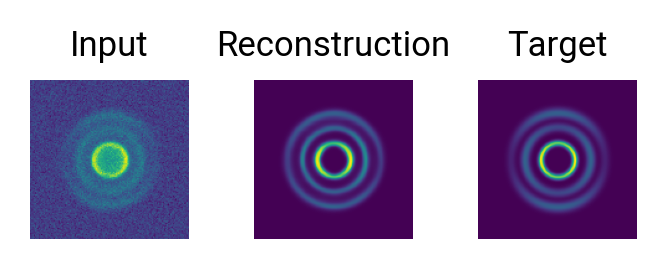

In [17]:
fig, axarray = plt.subplots(1, 3, figsize=(2.5, 1), sharex=True, sharey=True)

for ax, title, target in zip(axarray, ["Input", "Reconstruction", "Target"], [input_images, recon, target_images]):
    ax.imshow(target[image_index].squeeze())
    ax.set(title=title, yticks=[], xticks=[])
    for _, spine in ax.spines.items():
        spine.set_visible(False)
fig.tight_layout()
fig.savefig(f"{output_path}{model_name}_common_imgs.png", dpi=600)

### Compare radial profiles

In [18]:
if probabilistic:
    # get 200 samples from the posterior
    prob_recon = model_obj.predict(input_images[image_index], 200)
    prob_profiles = np.vstack([radial_profile(img.squeeze().numpy(), img_center) for img in prob_recon])
    # calculate sampling statistics
    profile_mean = prob_profiles.mean(axis=0)
    normalize = profile_mean.sum()
    profile_std = prob_profiles.std(axis=0)
    # get +/- one sigma and the mean
    upper, lower = (profile_mean + profile_std) / normalize, (profile_mean - profile_std) / normalize
    profile_mean /= normalize
    df = pd.DataFrame(data=list(zip(profile_mean, upper, lower)), columns=["Model", "Upper", "Lower"])
else:
    profile = model_obj.model_radial_profile(input_images[image_index])
    profile /= profile.sum()
    df = pd.DataFrame(data=profile, columns=["Model"])
    
for target, name in zip([input_images, target_images], ["Input", "Target"]):
    profile = radial_profile(target[image_index].squeeze().numpy(), img_center)
    norm = profile.sum()
    profile /= norm
    df[name] = profile

op_img = abel.Transform(input_images[image_index].squeeze().numpy(), method="onion_peeling").transform
op_profile = radial_profile(op_img, img_center)
op_profile /= op_profile.sum()
df["OnionPeeling"] = op_profile

In [19]:
# output the result for overlaying later
df.to_csv(f"{output_path}{model_name}_common_radial.csv")

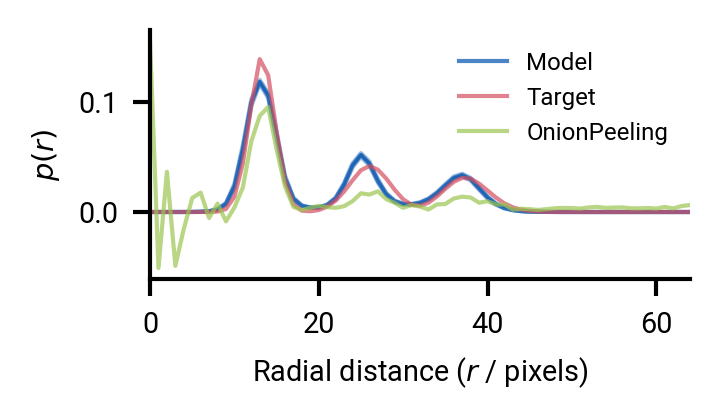

In [20]:
fig, ax = plt.subplots(figsize=(2.5, 1.5))

colors = ["#0051ad", "#d34e60", "#9ac54f"]

for key, color in zip(["Model", "Target", "OnionPeeling"], colors):
    ax.plot(df[key], lw=1., alpha=0.7, label=key, color=color)

# if we have a probabilistic model, shade in +/-1 sigma
if probabilistic:
    ax.fill_between(np.arange(df["Model"].size), df["Upper"], df["Lower"], color=colors[0], alpha=0.4)
    
ax.set(ylabel="$p(r)$", xlabel="Radial distance ($r$ / pixels)", xlim=[0., img_center[0]])
ax.legend(fontsize="xx-small")
fig.tight_layout()
fig.savefig(f"{output_path}{model_name}_common_radial.png", dpi=600)

### Radial error quantification

__For the sole exemplar image__

In [21]:
# true_quant, true_interp = get_profile_peaks(df.index, df["Target"])
# recon_quant, recon_interp = get_profile_peaks(df.index, df["Model"])

In [22]:
# quant_error = (np.square(true_quant - recon_quant)).mean()
# interp_error = ((np.square(true_interp - recon_interp)).mean() / df.index.size) * 100.

In [23]:
# print(f"Quantized pixel error is {quant_error:.2f} pixels")
# print(f"Interpolated relative error is {interp_error:.2f}%")

In [24]:
# # see what the centers actually are
# print(true_interp, recon_interp)

__Across the benchmark set__

In [25]:
true_num, pred_num = list(), list()
kl_divs = list()
for target, predicted in zip(target_images, recon):
    target_profile = radial_profile(target.squeeze().numpy(), img_center)
    recon_profile = radial_profile(predicted.squeeze().numpy(), img_center)
    kl = entropy(pk=target_profile, qk=recon_profile)
    kl_divs.append(kl)
    # get the peaks from the radial profile
    x = np.arange(target_profile.size)
    true_quant, true_interp = get_profile_peaks(x, target_profile)
    recon_quant, recon_interp = get_profile_peaks(x, recon_profile)
    true_num.append(len(true_quant))
    pred_num.append(len(recon_quant))

true_counts, bins = np.histogram(true_num, bins=np.arange(1, 6))
pred_counts, bins = np.histogram(pred_num, bins=np.arange(1, 6))

/home/kelvin/anaconda3/envs/ion-image/lib/python3.7/site-packages/peakutils/peak.py:246: UserWarning: At least 3 points required for Gaussian fitting
  warnings.warn(str(e))
/home/kelvin/anaconda3/envs/ion-image/lib/python3.7/site-packages/peakutils/peak.py:246: UserWarning: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
  warnings.warn(str(e))


In [26]:
print(f"Mean KL-divergence, representing the true distribution P with the predicted Q: {np.mean(kl_divs):.2f}")

Mean KL-divergence, representing the true distribution P with the predicted Q: 0.05


[Text(0, 0.5, 'Counts'), Text(0.5, 0, 'Number of centers detected')]

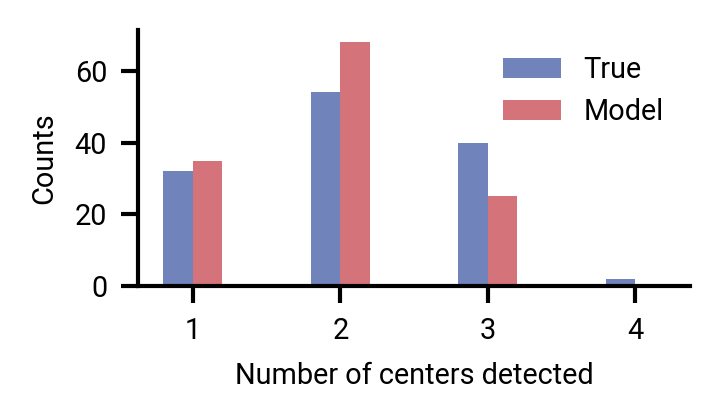

In [27]:
fig, ax= plt.subplots(figsize=(2.5, 1.5))

ax.bar(bins[:-1] - 0.1, true_counts, label="True", alpha=0.7, width=0.2)
ax.bar(bins[:-1] + 0.1, pred_counts, label="Model", alpha=0.7, width=0.2)
ax.legend(fontsize="x-small")
ax.set(ylabel="Counts", xlabel="Number of centers detected")

# Finalizing the results

In [28]:
yaml = YAML()

In [29]:
current = None
if os.path.isfile(agg_path):
    with open(agg_path, "r") as results_file:
        current = yaml.load(results_file)
if not current:
    current = dict()
current[f"{model_name}"] = {
    "kl-divergence": str(np.mean(kl_divs)),
    "dev_mean_recon": str(recon_error),
    "best_recon": str(best_error),
    "worst_recon": str(worst_error)
}
with open(agg_path, "w") as results_file:
    yaml.dump(current, results_file)